In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K

In [2]:
class PositionEncoding(Model):
    def __init__(self, model_dim):
        self.model_dim = model_dim
        super().__init__()
    def call(self, inputs):
        seq_length = inputs.shape[1]
        position_encodings = np.zeros((seq_length, self.model_dim))
        for pos in range(seq_length):
            for i in range(self.model_dim):
                position_encodings[pos, i] = pos / np.power(10000, (i-i%2) / self.model_dim)
        position_encodings[:, 0::2] = np.sin(position_encodings[:, 0::2])
        position_encodings[:, 1::2] = np.cos(position_encodings[:, 1::2])
        position_encodings = tf.expand_dims(tf.cast(position_encodings, tf.float32), axis=0)
        return position_encodings

In [3]:
class ScaledDotProductAttention(Model):
    def __init__(self, masking=True, future=False, dropout=0):
        self.masking = masking
        self.future = future
        self.dropout = dropout
        self.masking_num = -2**32+1
        super().__init__()
        
    def mask(self, inputs, masks):
        masks = tf.cast(masks, tf.float32)
        masks = tf.tile(masks, [tf.shape(inputs)[0] // tf.shape(masks)[0], 1])
        masks = tf.expand_dims(masks, axis=1)
        outputs = inputs + masks * self.masking_num
        return outputs
    
    def future_mask(self, inputs):
        diag_vals = tf.ones_like(inputs[0])
        tril = tf.linalg.LinearOperatorLowerTriangular(diag_vals).to_dense()
        future_masks = tf.tile(tf.expand_dims(tril, 0), [tf.shape(inputs)[0], 1, 1])
        paddings = tf.ones_like(future_masks) * self.masking_num
        outputs = tf.where(tf.equal(future_masks, 0), paddings, inputs)
        return outputs
        
    def call(self, inputs):
        if self.masking:
            assert len(inputs) == 4
            queries, keys, values, masks = inputs
        else:
            assert len(inputs) == 3
            queries, keys, values = inputs
        
        # dtype
        if queries.dtype != tf.float32:
            queries = tf.cast(queries, tf.float32)
        if keys.dtype != tf.float32:
            keys = tf.cast(keys, tf.float32)
        if values.dtype != tf.float32:
            values = tf.cast(values, tf.float32)
        
        matmul = tf.matmul(queries, tf.transpose(keys, [0, 2, 1]))
        scaled_matmul = matmul / tf.sqrt(tf.cast(queries.shape[-1], tf.float32))
        if self.masking:
            scaled_matmul = self.mask(scaled_matmul, masks)
        if self.future:
            scaled_matmul = self.future_mask(scaled_matmul)
        
        softmax_out = tf.nn.softmax(scaled_matmul)
        
#         out = Dropout(self.dropout)(softmax_out)
        out = tf.nn.dropout(softmax_out, self.dropout)
        outputs = tf.matmul(out, values)
        
        return outputs    

In [4]:
class MultiHeadAttention(Model):
    def __init__(self, n_heads, head_dim, dropout=.1, masking=True, 
                 future=False, trainable=True):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = head_dim
        self.dropout = dropout
        self.masking = masking
        self.future = future
        self.trainable = trainable
        self.q_dense = Dense(head_dim)
        self.k_dense = Dense(head_dim)
        self.v_dense = Dense(head_dim)
        
        
    
    def call(self, inputs):
        if self.masking:
            assert len(inputs) == 4
            queries, keys, values, masks = inputs
        else:
            assert len(inputs) == 3
            queries, keys, values = inputs
        
#         queries_linear = Dense(queries.shape[-1])(queries)
#         keys_linear = Dense(keys.shape[-1])(keys)
#         values_linear = Dense(values.shape[-1])(values)
        queries_linear = self.q_dense(queries)
        keys_linear = self.k_dense(keys)
        values_linear = self.v_dense(values)
        
        queries_multi_heads = tf.concat(tf.split(queries_linear, self.n_heads, axis=2), axis=0)
        keys_multi_heads = tf.concat(tf.split(keys_linear, self.n_heads, axis=2), axis=0)
        values_multi_heads = tf.concat(tf.split(values_linear, self.n_heads, axis=2), axis=0)
        
        if self.masking:
            att_inputs = [queries_multi_heads, keys_multi_heads, values_multi_heads, masks]
        else:
            att_inputs = [queries_multi_heads, keys_multi_heads, values_multi_heads]
        
        attention = ScaledDotProductAttention(masking=self.masking, future=self.future, 
                                             dropout=self.dropout)
        att_out = attention(att_inputs)
        
        outputs = tf.concat(tf.split(att_out, self.n_heads, axis=0), axis=2)
        
        return outputs

In [5]:
vocab_size = 5000
max_len = 256
model_dim = 512
batch_size = 64
epochs = 10

(x_train, y_train), (x_test, y_test) = imdb.load_data(maxlen=max_len, num_words=vocab_size)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
x_train_masks = tf.equal(x_train, 0)
x_test_masks = tf.equal(x_test, 0)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

inputs = Input(shape=(max_len,), name='inputs')
masks = Input(shape=(max_len,), name='masks')
embeddings = Embedding(vocab_size, model_dim)(inputs)
encodings = PositionEncoding(model_dim)(embeddings)
encodings = tf.keras.layers.add([embeddings, encodings])
x = MultiHeadAttention(8, 64)([encodings, encodings, encodings, masks])
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)
model = Model(inputs=[inputs, masks], outputs=outputs)

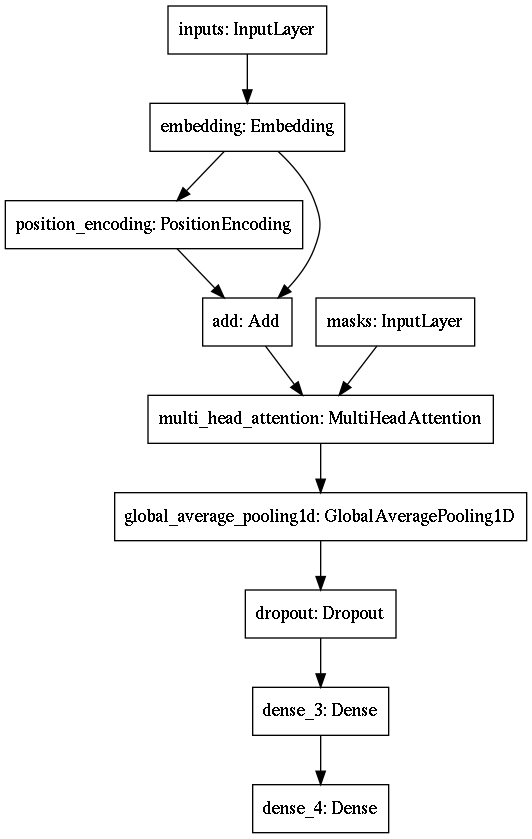

In [6]:
plot_model(model)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 512)     2560000     inputs[0][0]                     
__________________________________________________________________________________________________
position_encoding (PositionEnco (1, 256, 512)        0           embedding[0][0]                  
__________________________________________________________________________________________________
add (Add)                       (None, 256, 512)     0           embedding[0][0]                  
                                                                 position_encoding[0][0]      

In [8]:
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9), 
    loss='categorical_crossentropy', metrics=['accuracy'])

print("Model Training ... ")
es = EarlyStopping(patience=5)
model.fit([x_train, x_train_masks], y_train, 
          batch_size=batch_size, epochs=epochs, 
          validation_split=0.2, callbacks=[es])

test_metrics = model.evaluate([x_test, x_test_masks], y_test, batch_size=batch_size, verbose=0)
print("loss on Test: %.4f" % test_metrics[0])
print("accu on Test: %.4f" % test_metrics[1])

Model Training ... 
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 25s 1ms/sample - loss: 0.6941 - accuracy: 0.4983 - val_loss: 0.6934 - val_accuracy: 0.4916
Epoch 2/10
20000/20000 [==============================] - 23s 1ms/sample - loss: 0.6938 - accuracy: 0.5135 - val_loss: 0.6917 - val_accuracy: 0.5128
Epoch 3/10
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.6463 - accuracy: 0.5913 - val_loss: 0.5112 - val_accuracy: 0.7564
Epoch 4/10
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.4071 - accuracy: 0.8141 - val_loss: 0.3548 - val_accuracy: 0.8448
Epoch 5/10
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.2855 - accuracy: 0.8792 - val_loss: 0.3386 - val_accuracy: 0.8544
Epoch 6/10
20000/20000 [==============================] - 24s 1ms/sample - loss: 0.2058 - accuracy: 0.9179 - val_loss: 0.3719 - val_accuracy: 0.8490
Epoch 7/10
20000/20000 [=============